In [123]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy import  ndimage
import time
from scipy.signal import correlate2d

warnings.filterwarnings("ignore")

# LAB 2

### Retall de sub-imatges

In [124]:
def llegir_retallar(nombre_archivo):
    img = cv2.imread('imgs/' + str(nombre_archivo) + '.jpg', cv2.COLOR_BGR2GRAY)
    img1 = img[:img.shape[0]//3, :]
    img2 = img[img.shape[0]//3:(img.shape[0]//3)*2, :]
    img3 = img[(img.shape[0]//3)*2:, :]
    #plt.imshow(img1, cmap='gray')
    #plt.imshow(img2, cmap='gray')
    #plt.imshow(img3, cmap='gray')
    return [img1, img2, img3]





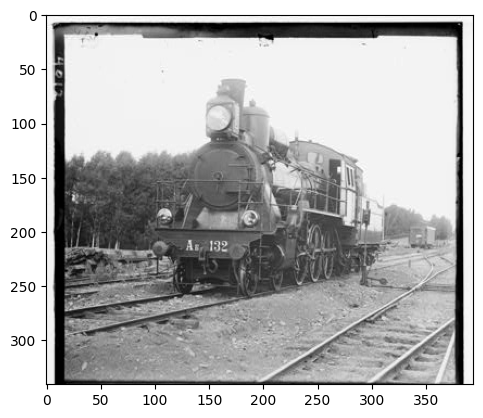

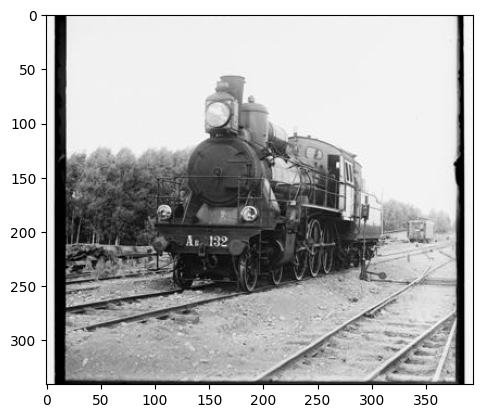

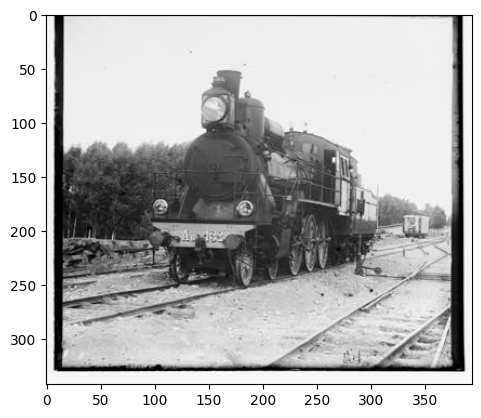

In [125]:
archivos = os.listdir('imgs')
archivos = [a.removesuffix('.jpg') for a in archivos if a.endswith('.jpg')]


def llegir_imatges(archivos):
    images = {}
    for i in archivos:
        img = llegir_retallar(i)
        images[i] = img
    return images
images = llegir_imatges(archivos)


plt.imshow(images[archivos[1]][0], cmap='gray')
plt.show()
plt.imshow(images[archivos[1]][1], cmap='gray')
plt.show()
plt.imshow(images[archivos[1]][2], cmap='gray')
plt.show()
    


In [199]:
def recortar_marcos(img, sencillo=True):
    if sencillo:
        return img[20:-20, 20:-20]
        
    gauss = cv2.GaussianBlur(img, (5,5), 0)

    _, binarizada = cv2.threshold(gauss, 20, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    contornos, _ = cv2.findContours(binarizada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    mayor_contorno = max(contornos, key=cv2.contourArea)
    
    x, y, w, h = cv2.boundingRect(mayor_contorno)
    
    imagen_recortada = img[y:y+h, x:x+w]
    
    return imagen_recortada

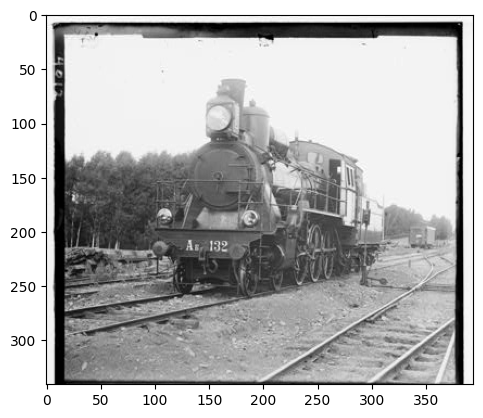

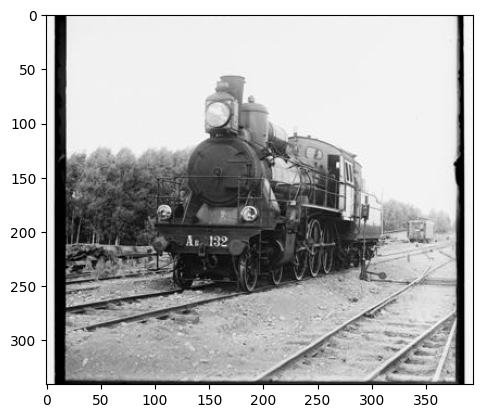

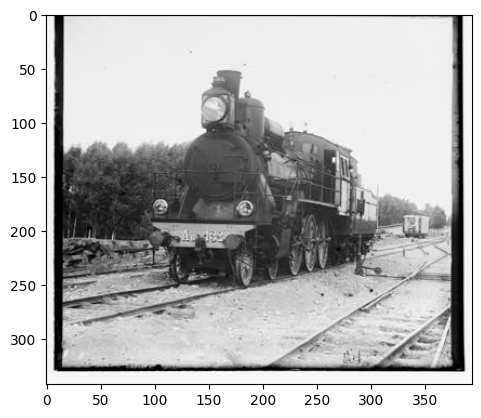

In [169]:

imagen1  = np.array(images[archivos[1]][0])
imagen2  = np.array(images[archivos[1]][1])
imagen3  = np.array(images[archivos[1]][2])
plt.imshow(imagen1, cmap='gray')
plt.show()
plt.imshow(imagen2, cmap='gray')
plt.show()
plt.imshow(imagen3, cmap='gray')
plt.show()

In [166]:
print(imagen1.shape, imagen2.shape, imagen3.shape)

(341, 394) (341, 394) (342, 394)


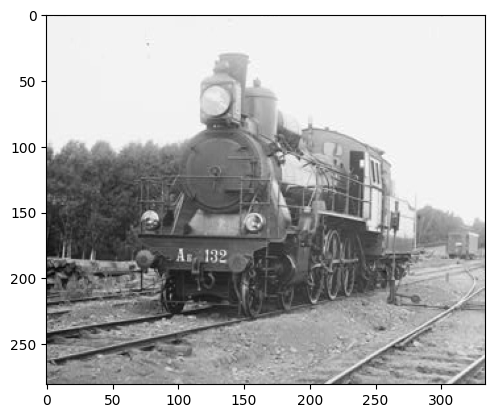

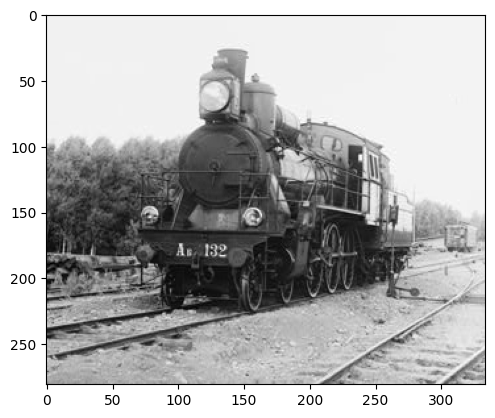

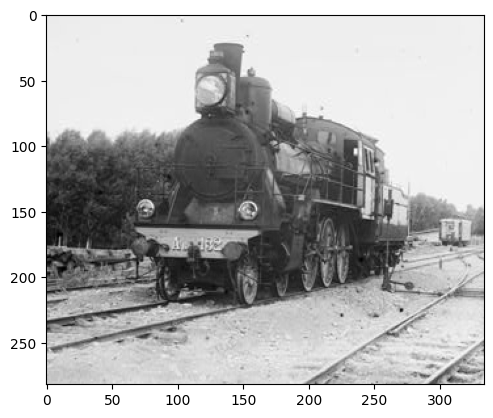

In [170]:
imagen1 = recortar_marcos(imagen1)
imagen2 = recortar_marcos(imagen2)
imagen3 = recortar_marcos(imagen3)
plt.imshow(imagen1, cmap='gray')
plt.show()
plt.imshow(imagen2, cmap='gray')
plt.show()
plt.imshow(imagen3, cmap='gray')
plt.show()

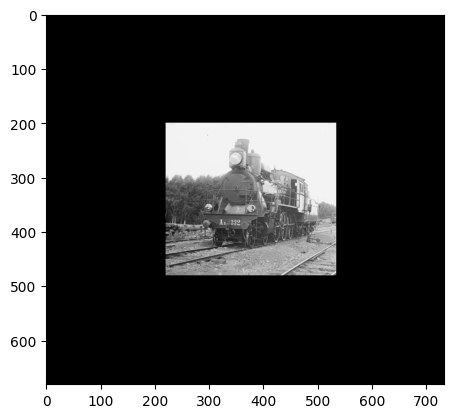

In [171]:
imagen1_desplazada = np.roll(imagen1, 20, axis=1)
imagen1_desplazada[:, :20] = 0
imagen1_desplazada = cv2.copyMakeBorder(imagen1_desplazada, 200, 200, 200, 200, cv2.BORDER_CONSTANT)

plt.imshow(imagen1_desplazada, cmap='gray')
plt.show()

(281, 334) (401, 401)


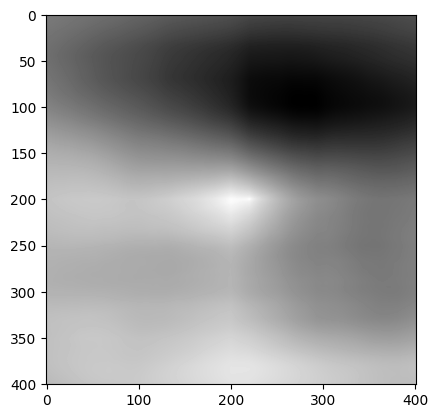

In [172]:
resultado_correlacion = cv2.matchTemplate(imagen1_desplazada, imagen1, cv2.TM_CCOEFF_NORMED)
#res = correlate2d(imagen1_desplazada, imagen1, mode='same')
print(imagen1.shape, resultado_correlacion.shape)
plt.imshow(resultado_correlacion, cmap='gray')
plt.show()


In [173]:
"""plt.imshow(res, cmap='gray')
plt.show()"""

"plt.imshow(res, cmap='gray')\nplt.show()"

In [174]:
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(resultado_correlacion)
max_val, max_loc


(0.7504279017448425, (220, 200))

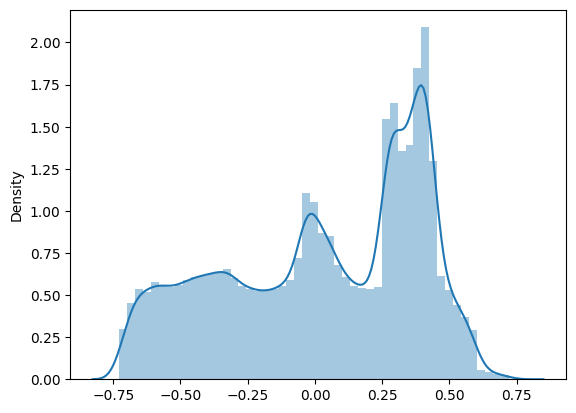

In [175]:
sns.distplot(resultado_correlacion.flatten())
plt.show()

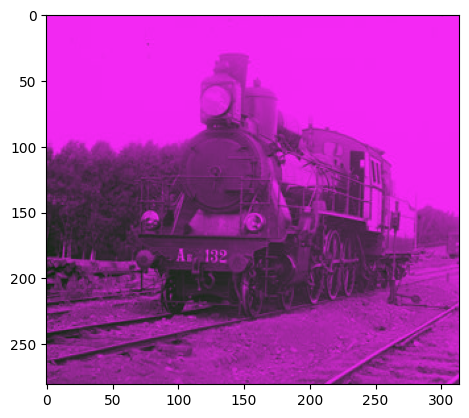

In [176]:
res = np.copy(imagen1_desplazada)
res = np.reshape(res, (res.shape[0], res.shape[1], 1))
res = np.concatenate([res, res, res], axis=2)

h, w = imagen1.shape[:2]
x = max_loc[0]
y = max_loc[1]
    
res[y:y+h, x:x+w,1] = 40

plt.imshow(res[200:-(200), 200 + 20:-(200), :])

### Funcion para alinear imagenes

In [177]:
CORRELACION_BASADA_CONVOlUCÍON = 0
CORRELACION_BASADA_CONVOlUCÍON_NORMALIZADA = 1
CORRELACION_BASADA_FOURIER = 2
CORRELACION_BASADA_ESPAI_FOURIER = 3
SIN_CORRELACION = 4

In [178]:
def calMax(imagen1, imagen2, imagen3):
    if(imagen1.shape[0]*imagen1.shape[1] > imagen2.shape[0]*imagen2.shape[1] and imagen1.shape[0]*imagen1.shape[1] > imagen3.shape[0]*imagen3.shape[1]):
        return 1
    elif(imagen2.shape[0]*imagen2.shape[1] > imagen3.shape[0]*imagen3.shape[1]):
        return 2
    else:
        return 3

In [179]:
def alinear_imagenes(imagen1, imagen2, imagen3, metodo=CORRELACION_BASADA_CONVOlUCÍON):
        
    altura_img, ancho_img = imagen1.shape[:2]
    altura_plantilla, ancho_plantilla = imagen2.shape[:2]
    pad_alto = altura_plantilla - 1
    pad_ancho = ancho_plantilla - 1

    imagen_padded = cv2.copyMakeBorder(imagen1, pad_alto, pad_alto, pad_ancho, pad_ancho, cv2.BORDER_CONSTANT)

    res = np.copy(imagen_padded)
    res = np.reshape(res, (res.shape[0], res.shape[1], 1))
    res = np.concatenate([res, res, res], axis=2)
    
    #pfimera correlacion, imagen1 con imagen2
    if metodo == CORRELACION_BASADA_CONVOlUCÍON:
        resultado_correlacion1 = cv2.matchTemplate(imagen_padded, imagen2, cv2.TM_CCOEFF)
        resultado_correlacion2 = cv2.matchTemplate(imagen_padded, imagen3, cv2.TM_CCOEFF)
        
    elif metodo == CORRELACION_BASADA_CONVOlUCÍON_NORMALIZADA:
        resultado_correlacion1 = cv2.matchTemplate(imagen_padded, imagen2, cv2.TM_CCORR_NORMED)
        resultado_correlacion2 = cv2.matchTemplate(imagen_padded, imagen3, cv2.TM_CCORR_NORMED)

    elif metodo == CORRELACION_BASADA_FOURIER:
        maxim  = calMax(imagen1, imagen2, imagen3)
        if maxim == 1:
            plantilla1 =  np.resize(imagen2, (imagen3.shape[0], imagen3.shape[1]))
            plantilla2 =  np.resize(imagen3, (imagen3.shape[0], imagen3.shape[1]))
            img = imagen1
        elif maxim == 2:
            plantilla1 =  np.resize(imagen1, (imagen3.shape[0], imagen3.shape[1]))
            plantilla2 =  np.resize(imagen3, (imagen3.shape[0], imagen3.shape[1]))
            img = imagen2
        else:   
            plantilla1 =  np.resize(imagen1, (imagen3.shape[0], imagen3.shape[1]))
            plantilla2 =  np.resize(imagen2, (imagen3.shape[0], imagen3.shape[1]))
            img = imagen3
        #iniciar matriz de resultado
        res = np.copy(img)
        res = np.reshape(res, (res.shape[0], res.shape[1], 1))
        res = np.concatenate([res, res, res], axis=2)
        
        #calcular la fft de las imagenes im1 y im2
        fft_imagen1 = np.fft.fft2(img)
        fft_imagen2 = np.fft.fft2(plantilla1)

        #calcular las fases de las imagenes
        fase_imagen1 = np.angle(fft_imagen1)
        fase_imagen2 = np.angle(fft_imagen2)
        #didferencia de fases
        dif_fase = fase_imagen1 - fase_imagen2

        #inversa de la fft de la diferencia de fases
        dif_fase_imagen = np.fft.ifft2(np.exp(1j * dif_fase))

        #calcular desplazaminento donde la correlacion es maxima 
        y, x = np.unravel_index(np.argmax(np.abs(dif_fase_imagen)), dif_fase_imagen.shape)
        imagen_alineada = np.roll(plantilla1, shift=(y, x), axis=(0, 1))
        max_val1 = np.max(np.abs(dif_fase_imagen))
        #añadir la imagen alineada a la matriz de resultado
        res[:, :,1] = imagen_alineada

        #calcular la fft y fasse de las imagenes im3
        fft_imagen2 = np.fft.fft2(plantilla2)
        fase_imagen2 = np.angle(fft_imagen2)

        #calcular diferencia de fases
        dif_fase = fase_imagen1 - fase_imagen2
        dif_fase_imagen = np.fft.ifft2(np.exp(1j * dif_fase))

        #calcular desplazaminiento donde la correlacion es maxima
        y, x = np.unravel_index(np.argmax(np.abs(dif_fase_imagen)), dif_fase_imagen.shape)
        imagen_alineada = np.roll(plantilla1, shift=(y, x), axis=(0, 1))
        max_val2 = np.max(np.abs(dif_fase_imagen))

        #añadir la imagen alineada a la matriz de resultado
        res[:, :,2] = imagen_alineada
        return res, max_val1, max_val2




    elif metodo == CORRELACION_BASADA_ESPAI_FOURIER:
        maxim  = calMax(imagen1, imagen2, imagen3)
        if maxim == 1:
            plantilla1 =  np.resize(imagen2, (imagen3.shape[0], imagen3.shape[1]))
            plantilla2 =  np.resize(imagen3, (imagen3.shape[0], imagen3.shape[1]))
            img = imagen1
        elif maxim == 2:
            plantilla1 =  np.resize(imagen1, (imagen3.shape[0], imagen3.shape[1]))
            plantilla2 =  np.resize(imagen3, (imagen3.shape[0], imagen3.shape[1]))
            img = imagen2
        else:   
            plantilla1 =  np.resize(imagen1, (imagen3.shape[0], imagen3.shape[1]))
            plantilla2 =  np.resize(imagen2, (imagen3.shape[0], imagen3.shape[1]))
            img = imagen3
    
        
        f1 = np.fft.fft2(img)
        f2 = np.fft.fft2(plantilla1)
        inversa = np.fft.ifft2(f1 * np.conj(f2))

        y, x = np.unravel_index(np.argmax(inversa), inversa.shape)

        res = np.copy(img)
        res = np.reshape(res, (res.shape[0], res.shape[1], 1))
        res = np.concatenate([res, res, res], axis=2)

        imagen1_alineada = np.roll(plantilla1, shift=(y, x), axis=(0, 1))
        max_val1 = np.max(inversa)
        res[:, :,1] = imagen1_alineada

        f2 = np.fft.fft2(plantilla2)
        inversa = np.fft.ifft2(f1 * np.conj(f2))

        y, x = np.unravel_index(np.argmax(inversa), inversa.shape)

        imagen2_alineada = np.roll(plantilla2, shift=(y, x), axis=(0, 1))
        max_val2 = np.max(inversa)

        res[:, :,2] = imagen2_alineada


        return res, max_val1, max_val2
    elif metodo == SIN_CORRELACION:
        res = np.copy(imagen1)
        res = np.reshape(res, (res.shape[0], res.shape[1], 1))
        res = np.concatenate([res, res, res], axis=2)

        plantilla1 =  np.resize(imagen2, (imagen1.shape[0], imagen1.shape[1]))
        plantilla2 =  np.resize(imagen3, (imagen1.shape[0], imagen1.shape[1]))

        res[:,:, 1] = plantilla1
        res[:,:, 2] = plantilla2
        return res, 0,0  
    
    _, max_val1, _, max_loc = cv2.minMaxLoc(resultado_correlacion1)
    
    
    h, w = imagen2.shape[:2]
    x = max_loc[0]
    y = max_loc[1]
    
    res[y:y+h, x:x+w,1] = imagen2
    
    _, max_val2, _, max_loc = cv2.minMaxLoc(resultado_correlacion2)
        
    h, w = imagen3.shape[:2]
    x = max_loc[0]
    y = max_loc[1]
    
    res[y:y+h, x:x+w,2] = imagen3

    return res[pad_alto:-(pad_alto), pad_ancho:-(pad_ancho), :], max_val1, max_val2

### Test de las imagenes

In [184]:

imagen1 = recortar_marcos(np.array(images[archivos[7]][0]))
imagen2 = recortar_marcos(np.array(images[archivos[7]][1]))
imagen3 = recortar_marcos(np.array(images[archivos[7]][2]))

In [185]:
imagen1.shape, imagen2.shape, imagen3.shape

((281, 337), (281, 337), (282, 337))

In [186]:
res, _, _  = alinear_imagenes(imagen1, imagen2, imagen3, metodo=SIN_CORRELACION)

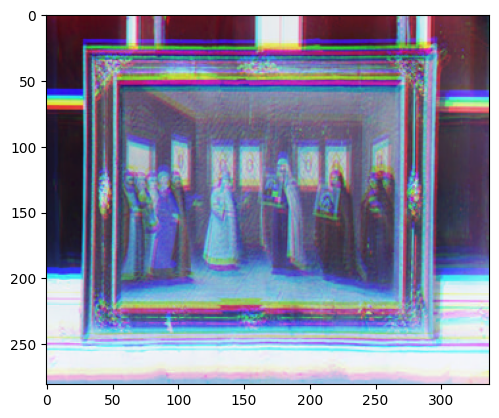

In [187]:
plt.imshow(res)
plt.show()

#### Correlació basada en convolució en l'espai

In [188]:
res, _ , _ = alinear_imagenes(imagen1, imagen2, imagen3, metodo=CORRELACION_BASADA_CONVOlUCÍON)

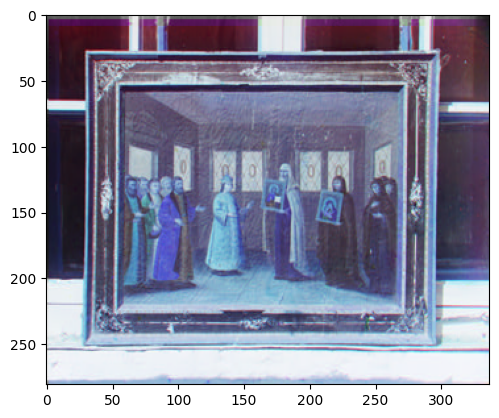

In [189]:
plt.imshow(res)
plt.show()

#### Correlació basada en convloució en l'espai normalaitzada

In [190]:
res, _ , _= alinear_imagenes(imagen1, imagen2, imagen3, metodo=CORRELACION_BASADA_CONVOlUCÍON_NORMALIZADA)

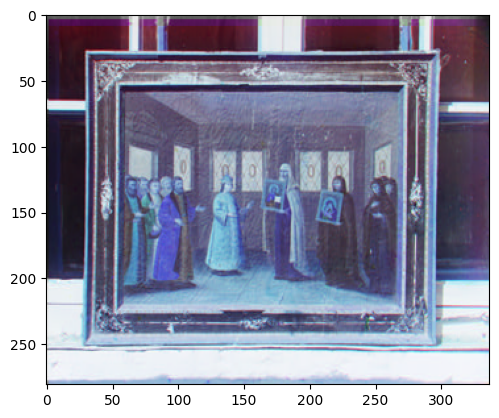

In [191]:
plt.imshow(res)
plt.show()

#### CORRELACIÓ BASADA ESPAI FOURIER

In [192]:
res, _ , _ = alinear_imagenes(imagen1, imagen2, imagen3, metodo=CORRELACION_BASADA_ESPAI_FOURIER)

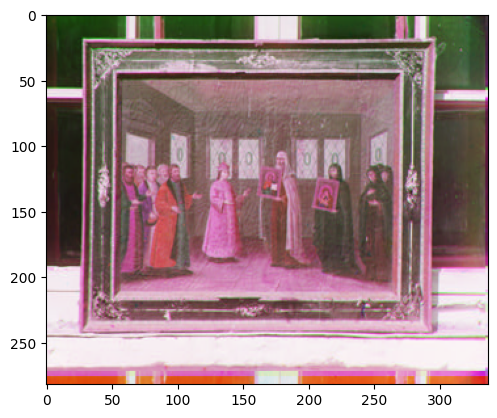

In [193]:
plt.imshow(res)
plt.show()

#### Correlació basada en fase 

In [194]:
res, max_val1, max_val2 = alinear_imagenes(imagen1, imagen2, imagen3, metodo=CORRELACION_BASADA_FOURIER)

In [195]:
max_val1, max_val2

(0.21018357468038662, 0.5848597114846432)

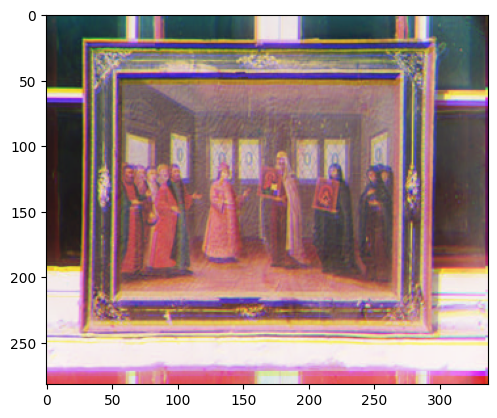

In [196]:
plt.imshow(res)
plt.show()

### Backtest de todas las imagenes

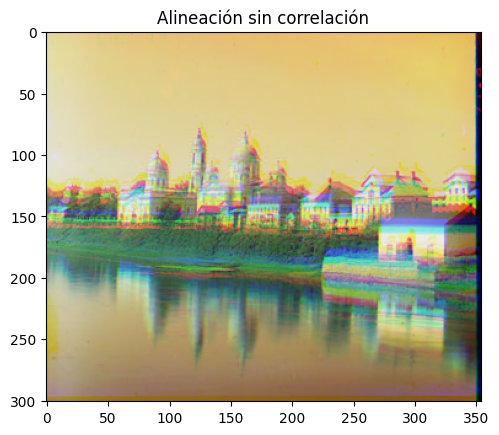


----------------------------------------------------------------



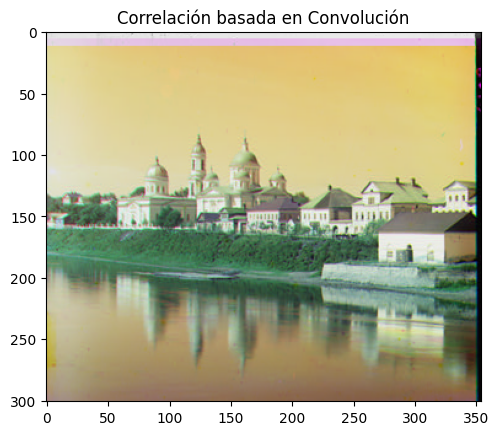

Correlacion con las diferentes imagenes: 304289216.0 206526816.0
Tiempo Correlacion (Convolución): 0.06945085525512695 s

----------------------------------------------------------------



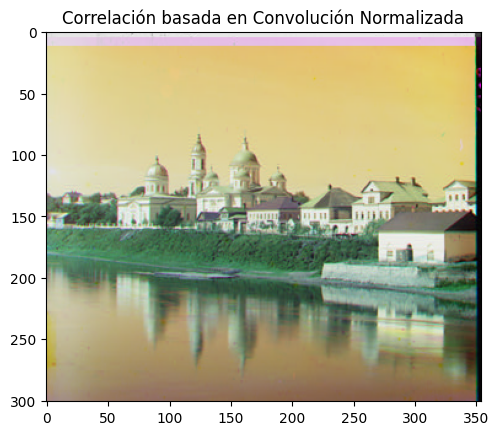

Correlacion con las diferentes imagenes: 0.9858671426773071 0.9558056592941284
Tiempo Correlacion (Convolución Normalizada): 0.06677603721618652 s

----------------------------------------------------------------



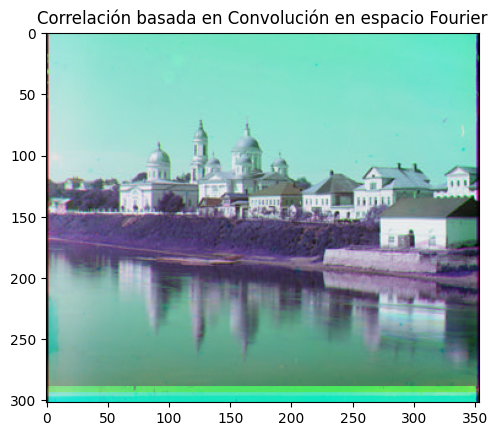

Correlacion con las diferentes imagenes: (2308764476.9999995+1.3448961767365534e-08j) (2244167041.9999995-4.694421067419523e-10j)
Tiempo Correlacion (Convolución en espacio Fourier): 0.0771629810333252 s

----------------------------------------------------------------



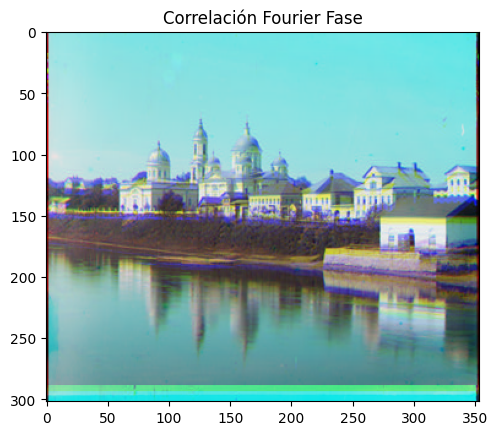

Correlacion con las diferentes imagenes: 0.28330533593490304 0.360600330580082
Tiempo Correlacion (Fourier Fase): 0.08653807640075684 s

--------------------------------------------------------------------------------------------------------------------------------



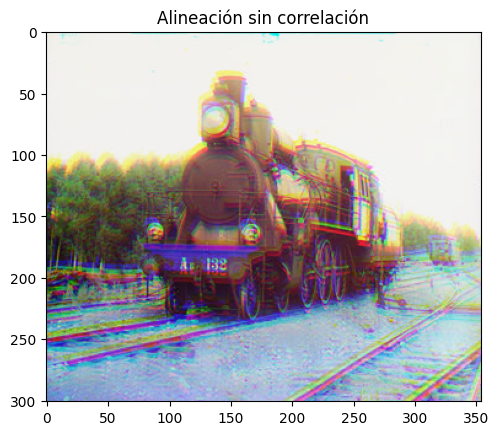


----------------------------------------------------------------



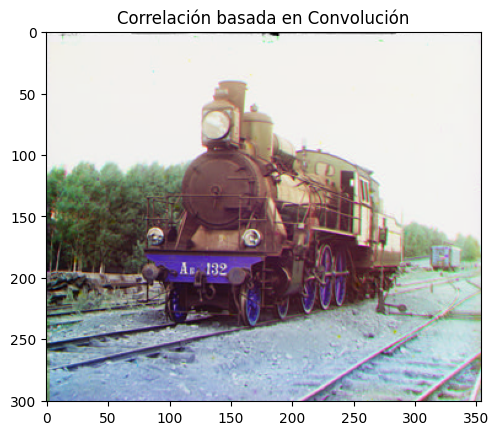

Correlacion con las diferentes imagenes: 503853216.0 428814720.0
Tiempo Correlacion (Convolución): 0.13219118118286133 s

----------------------------------------------------------------



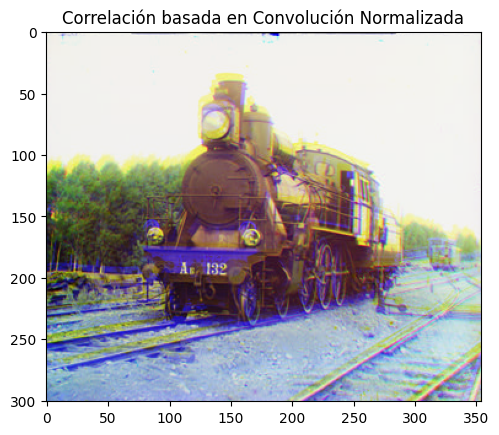

Correlacion con las diferentes imagenes: 0.9836325645446777 0.9598867297172546
Tiempo Correlacion (Convolución Normalizada): 0.0631721019744873 s

----------------------------------------------------------------



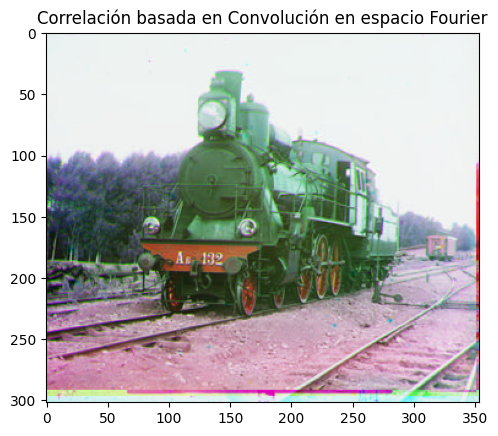

Correlacion con las diferentes imagenes: (3553026629.999999+5.1185257093355125e-08j) (3609609589.000001+1.1589693264124017e-08j)
Tiempo Correlacion (Convolución en espacio Fourier): 0.06793498992919922 s

----------------------------------------------------------------



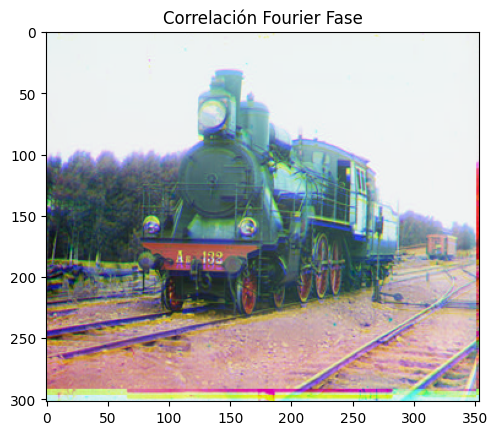

Correlacion con las diferentes imagenes: 0.2112773959349872 0.38475891402938356
Tiempo Correlacion (Fourier Fase): 0.08614802360534668 s

--------------------------------------------------------------------------------------------------------------------------------



In [202]:
def funcioFinal(marcos=True):

    if not os.path.isdir('imgsColor'):
            os.makedirs('imgsColor')

    archivos = os.listdir('imgs')
    archivos = [a.removesuffix('.jpg') for a in archivos if a.endswith('.jpg')]
    images = llegir_imatges(archivos)
    for a in archivos:

        if not os.path.isdir(f'imgsColor/{a}'):
            os.makedirs(f'imgsColor/{a}')

        imagen1  = np.array(images[a][0])
        imagen2  = np.array(images[a][1])
        imagen3  = np.array(images[a][2])

        if marcos:
            imagen1 = recortar_marcos(imagen1)
            imagen2 = recortar_marcos(imagen2)
            imagen3 = recortar_marcos(imagen3)

        #CORRELACION BASADA EN FASE FOURIER
        start_time = time.time()
        res, max_val1, max_val2 = alinear_imagenes(imagen1, imagen2, imagen3, metodo=SIN_CORRELACION)
        end_time = time.time()
        plt.imshow(res)
        plt.title('Alineación sin correlación')
        plt.show()
        print("")
        print("----------------------------------------------------------------")
        print("")
        plt.imsave('imgsColor/'+ a +"/" + a + '_sin_correlacion.jpg', res)
        
        #CORRELACION BASADA EN CONVOLUCION
        start_time = time.time()
        res, max_val1, max_val2 = alinear_imagenes(imagen1, imagen2, imagen3, metodo=CORRELACION_BASADA_CONVOlUCÍON)
        end_time = time.time()
        plt.imshow(res)
        plt.title('Correlación basada en Convolución')
        plt.show()
        print("Correlacion con las diferentes imagenes: " + str(max_val1) + " " + str(max_val2))
        print("Tiempo Correlacion (Convolución): " + str(end_time - start_time) + " s")
        print("")
        print("----------------------------------------------------------------")
        print("")
        plt.imsave('imgsColor/'+ a + "/" + a + '_correlacion_convolucion.jpg', res)

        #CORRELACION BASADA EN CONVOLUCION NORMALIZADA
        start_time = time.time()
        res, max_val1, max_val2 = alinear_imagenes(imagen1, imagen2, imagen3, metodo=CORRELACION_BASADA_CONVOlUCÍON_NORMALIZADA)
        end_time = time.time()
        plt.imshow(res)
        plt.title('Correlación basada en Convolución Normalizada')
        plt.show()
        print("Correlacion con las diferentes imagenes: " + str(max_val1) + " " + str(max_val2))
        print("Tiempo Correlacion (Convolución Normalizada): " + str(end_time - start_time) + " s")
        print("")
        print("----------------------------------------------------------------")
        print("")
        plt.imsave('imgsColor/'+ a +"/" + a + '_correlacion_convolucion_norm.jpg', res)

        #CORRELACION BASADA EN ESPAI FOURIER
        start_time = time.time()
        res, max_val1, max_val2 = alinear_imagenes(imagen1, imagen2, imagen3, metodo=CORRELACION_BASADA_ESPAI_FOURIER)
        end_time = time.time()
        plt.imshow(res)
        plt.title('Correlación basada en Convolución en espacio Fourier')
        plt.show()
        print("Correlacion con las diferentes imagenes: " + str(max_val1) + " " + str(max_val2))
        print("Tiempo Correlacion (Convolución en espacio Fourier): " + str(end_time - start_time) + " s")
        print("")
        print("----------------------------------------------------------------")
        print("")
        plt.imsave('imgsColor/'+ a +"/" + a + '_correlacion_convolucion_espaiFourier.jpg', res)

        #CORRELACION BASADA EN FASE FOURIER
        start_time = time.time()
        res, max_val1, max_val2 = alinear_imagenes(imagen1, imagen2, imagen3, metodo=CORRELACION_BASADA_FOURIER)
        end_time = time.time()
        plt.imshow(res)
        plt.title('Correlación Fourier Fase')
        plt.show()
        print("Correlacion con las diferentes imagenes: " + str(max_val1) + " " + str(max_val2))
        print("Tiempo Correlacion (Fourier Fase): " + str(end_time - start_time) + " s")
        print("")
        print("--------------------------------------------------------------------------------------------------------------------------------")
        print("")
        plt.imsave('imgsColor/'+ a +"/" + a + '_correlacion_convolucion_faseFourier.jpg', res)

        #Guardem imatge Convolució Normalitzada ja que es la que dona millor resultat en poc temps
        
                
        
start_time = time.time()
funcioFinal()
end_time = time.time()